In [1]:
import os
import glob
import random

import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

from utils import *

/home/am/.conda/envs/DD-Net/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/am/.conda/envs/DD-Net/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/am/.conda/envs/DD-Net/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/am/.conda/envs/DD-Net/lib/python3.7/site-packages/tensorflow/

In [2]:
os.system('rm -r weights*')

0

# Initialize the setting

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
random.seed(1234)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 14 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.clc_num = 3 # the number of class
        self.feat_d = 91
        self.filters = 64
        self.data_dir = './JHMDB_processed/'
C = Config()
lr = 1e-4
class_weight = {0: 1, 1: 1.5, 2:1}

In [5]:
def data_generator(T,C,le):
    X_0 = []
    X_1 = []
    Y = []
    for i in tqdm(range(len(T['pose']))): 
        p = np.copy(T['pose'][i])
        x_scaled = norm_scale(p[:, : , 0])
        y_scaled = norm_scale(p[:, : , 1])
        p = np.stack((x_scaled, y_scaled), axis=-1)
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
        label = np.zeros(C.clc_num)
        label[le.transform(T['label'])[i]-1] = 1   

        M = get_CG(p,C)

        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
    return X_0,X_1,Y

# Building the model

In [6]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    H, W = P.get_shape()[-2],P.get_shape()[-1]
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l, H*W))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),H*W))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)


def build_DD_Net(C):
    M = Input(name='M', shape=(C.frame_l,C.feat_d))  
    P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d)) 
    
    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.1)(x)
    x = d1D(x,128)
    x = Dropout(0.1)(x)
    x = Dense(C.clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model


# def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
#     M = Input(shape=(frame_l,feat_d))
#     P = Input(shape=(frame_l,joint_n,joint_d))
    
#     diff_slow,diff_fast = pose_motion(P,frame_l)
    
#     x = c1D(M,filters*2,1)
# #     x = SpatialDropout1D(0.1)(x)
#     x = BatchNormalization()(x)
#     x = c1D(x,filters,3)
# #     x = SpatialDropout1D(0.1)(x)
#     x = BatchNormalization()(x)
#     x = c1D(x,filters,1)
#     x = MaxPooling1D(2)(x)
# #     x = SpatialDropout1D(0.1)(x)
#     x = BatchNormalization()(x)

#     x_d_slow = c1D(diff_slow,filters*2,1)
# #     x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
#     x_d_slow = BatchNormalization()(x_d_slow)
#     x_d_slow = c1D(x_d_slow,filters,3)
# #     x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
#     x_d_slow = BatchNormalization()(x_d_slow)
#     x_d_slow = c1D(x_d_slow,filters,1)
#     x_d_slow = MaxPool1D(2)(x_d_slow)
# #     x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
#     x_d_slow = BatchNormalization()(x_d_slow)
        
#     x_d_fast = c1D(diff_fast,filters*2,1)
# #     x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
#     x_d_fast = BatchNormalization()(x_d_fast)
#     x_d_fast = c1D(x_d_fast,filters,3) 
# #     x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
#     x_d_fast = BatchNormalization()(x_d_fast)
#     x_d_fast = c1D(x_d_fast,filters,1) 
# #     x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
#     x_d_fast = BatchNormalization()(x_d_fast)
   
#     x = concatenate([x,x_d_slow,x_d_fast])
#     x = block(x,filters*2)
#     x = MaxPool1D(2)(x)
# #     x = SpatialDropout1D(0.1)(x)
#     x = BatchNormalization()(x)
    
#     x = block(x,filters*4)
#     x = MaxPool1D(2)(x)
# #     x = SpatialDropout1D(0.1)(x)
#     x = BatchNormalization()(x)

#     x = block(x,filters*8)
# #     x = SpatialDropout1D(0.1)(x)
#     x = BatchNormalization()(x)
    
#     return Model(inputs=[M,P],outputs=x)


# def build_DD_Net(C):
#     M = Input(name='M', shape=(C.frame_l,C.feat_d))  
#     P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d)) 
    
#     FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)
    
#     x = FM([M,P])

#     x = GlobalMaxPool1D()(x)
    
#     x = d1D(x,128)
# #     x = Dropout(0.1)(x)
#     x = BatchNormalization()(x)
#     x = d1D(x,128)
# #     x = Dropout(0.1)(x)
#     x = BatchNormalization()(x)
#     x = Dense(C.clc_num, activation='softmax')(x)
    
#     ######################Self-supervised part
#     model = Model(inputs=[M,P],outputs=x)
#     return model

In [7]:
DD_Net = build_DD_Net(C)
DD_Net.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  [(None, 32, 91)]     0                                            
__________________________________________________________________________________________________
P (InputLayer)                  [(None, 32, 14, 2)]  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 4, 512)       1712512     M[0][0]                          
                                                                 P[0][0]                          
_________________________________________________________________________

## Train and test on GT_split 1

In [8]:
Train_1 = pickle.load(open(C.data_dir+"GT_train_1.pkl", "rb"))
Test_1 = pickle.load(open(C.data_dir+"GT_test_1.pkl", "rb"))

le = preprocessing.LabelEncoder()
le.fit(Train_1['label'])
print(le.classes_)

X_0,X_1,Y = data_generator(Train_1,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test_1,C,le)

 38%|███▊      | 34/90 [00:00<00:00, 335.97it/s]

['catch' 'sit' 'walk']


100%|██████████| 38/38 [00:00<00:00, 348.93it/s]


In [9]:
DD_Net.compile(loss="categorical_crossentropy",optimizer=Adam(lr),metrics=['accuracy'])
lrScheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
modelCpkt = ModelCheckpoint('./weights_split_1/epoch_{epoch:02d}-val_acc_{val_acc:.2f}', monitor='val_acc', 
                            mode='max', save_best_only=True, save_weights_only=True, 
                            load_weights_on_restart=True)
history = DD_Net.fit([X_0,X_1], Y, 
                     batch_size=len(Y),
                     epochs=700,
                     verbose=True,
                     shuffle=True,
                     callbacks=[lrScheduler, modelCpkt],
                     validation_data=([X_test_0,X_test_1],Y_test),
                     class_weight=class_weight
                     )

Train on 90 samples, validate on 38 samples
Epoch 1/700
90/90 [==============================] - 2s 26ms/sample - loss: 1.7279 - acc: 0.3333 - val_loss: 1.0989 - val_acc: 0.2895
Epoch 2/700
90/90 [==============================] - 0s 1ms/sample - loss: 1.5595 - acc: 0.3444 - val_loss: 1.0977 - val_acc: 0.3947
Epoch 3/700
90/90 [==============================] - 0s 1ms/sample - loss: 1.4727 - acc: 0.4333 - val_loss: 1.0967 - val_acc: 0.3947
Epoch 4/700
90/90 [==============================] - 0s 1ms/sample - loss: 1.1521 - acc: 0.5667 - val_loss: 1.0957 - val_acc: 0.3947
Epoch 5/700
90/90 [==============================] - 0s 1ms/sample - loss: 1.1173 - acc: 0.5444 - val_loss: 1.0951 - val_acc: 0.3947
Epoch 6/700
90/90 [==============================] - 0s 2ms/sample - loss: 1.0294 - acc: 0.5667 - val_loss: 1.0948 - val_acc: 0.4474
Epoch 7/700
90/90 [==============================] - 0s 2ms/sample - loss: 1.0676 - acc: 0.6000 - val_loss: 1.0944 - val_acc: 0.5000
Epoch 8/700
90/90 [=====

Epoch 62/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0979 - acc: 0.9778 - val_loss: 1.1420 - val_acc: 0.3158
Epoch 63/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0577 - acc: 1.0000 - val_loss: 1.1442 - val_acc: 0.3158
Epoch 64/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1144 - acc: 0.9778 - val_loss: 1.1458 - val_acc: 0.3158
Epoch 65/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0798 - acc: 0.9889 - val_loss: 1.1474 - val_acc: 0.3158
Epoch 66/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0640 - acc: 1.0000 - val_loss: 1.1500 - val_acc: 0.3158
Epoch 67/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0881 - acc: 0.9778 - val_loss: 1.1528 - val_acc: 0.3158
Epoch 68/700
90/90 [==============================] - 0s 3ms/sample - loss: 0.0737 - acc: 0.9667 - val_loss: 1.1555 - val_acc: 0.3158
Epoch 69/700
90/90 [==============================] - 0s 1ms/s

Epoch 123/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0662 - acc: 0.9778 - val_loss: 1.2784 - val_acc: 0.3158
Epoch 124/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0657 - acc: 0.9889 - val_loss: 1.2801 - val_acc: 0.3158
Epoch 125/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0465 - acc: 1.0000 - val_loss: 1.2814 - val_acc: 0.3158
Epoch 126/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1169 - acc: 0.9778 - val_loss: 1.2830 - val_acc: 0.3158
Epoch 127/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0635 - acc: 0.9889 - val_loss: 1.2838 - val_acc: 0.3158
Epoch 128/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0561 - acc: 1.0000 - val_loss: 1.2850 - val_acc: 0.3158
Epoch 129/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0689 - acc: 0.9889 - val_loss: 1.2862 - val_acc: 0.3158
Epoch 130/700
90/90 [==============================] - 

Epoch 184/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0687 - acc: 0.9889 - val_loss: 1.2257 - val_acc: 0.3684
Epoch 185/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0662 - acc: 0.9778 - val_loss: 1.2234 - val_acc: 0.3947
Epoch 186/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0592 - acc: 1.0000 - val_loss: 1.2200 - val_acc: 0.3947
Epoch 187/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0560 - acc: 1.0000 - val_loss: 1.2178 - val_acc: 0.3947
Epoch 188/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0671 - acc: 0.9889 - val_loss: 1.2146 - val_acc: 0.3947
Epoch 189/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0861 - acc: 0.9889 - val_loss: 1.2112 - val_acc: 0.3947
Epoch 190/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0465 - acc: 0.9889 - val_loss: 1.2077 - val_acc: 0.3947
Epoch 191/700
90/90 [==============================] - 

Epoch 245/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0781 - acc: 0.9889 - val_loss: 0.9113 - val_acc: 0.5789
Epoch 246/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0651 - acc: 0.9889 - val_loss: 0.9063 - val_acc: 0.5789
Epoch 247/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0793 - acc: 0.9889 - val_loss: 0.9005 - val_acc: 0.5789
Epoch 248/700
90/90 [==============================] - 0s 2ms/sample - loss: 0.0447 - acc: 0.9889 - val_loss: 0.8940 - val_acc: 0.6053
Epoch 249/700
90/90 [==============================] - 0s 2ms/sample - loss: 0.0528 - acc: 0.9889 - val_loss: 0.8870 - val_acc: 0.6316
Epoch 250/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0472 - acc: 1.0000 - val_loss: 0.8811 - val_acc: 0.6316
Epoch 251/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0891 - acc: 0.9889 - val_loss: 0.8748 - val_acc: 0.6316
Epoch 252/700
90/90 [==============================] - 

Epoch 306/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0421 - acc: 1.0000 - val_loss: 0.6312 - val_acc: 0.6842
Epoch 307/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0497 - acc: 1.0000 - val_loss: 0.6291 - val_acc: 0.6842
Epoch 308/700
90/90 [==============================] - 0s 2ms/sample - loss: 0.0534 - acc: 0.9889 - val_loss: 0.6271 - val_acc: 0.7105
Epoch 309/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0568 - acc: 0.9889 - val_loss: 0.6231 - val_acc: 0.7105
Epoch 310/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0371 - acc: 1.0000 - val_loss: 0.6194 - val_acc: 0.7105
Epoch 311/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0512 - acc: 0.9889 - val_loss: 0.6159 - val_acc: 0.7105
Epoch 312/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0805 - acc: 0.9778 - val_loss: 0.6141 - val_acc: 0.7105
Epoch 313/700
90/90 [==============================] - 

Epoch 367/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0517 - acc: 0.9889 - val_loss: 0.5121 - val_acc: 0.7632
Epoch 368/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0459 - acc: 1.0000 - val_loss: 0.5112 - val_acc: 0.7632
Epoch 369/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0877 - acc: 0.9778 - val_loss: 0.5105 - val_acc: 0.7632
Epoch 370/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0401 - acc: 1.0000 - val_loss: 0.5095 - val_acc: 0.7632
Epoch 371/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0525 - acc: 0.9889 - val_loss: 0.5081 - val_acc: 0.7632
Epoch 372/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0426 - acc: 0.9889 - val_loss: 0.5071 - val_acc: 0.7632
Epoch 373/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0458 - acc: 1.0000 - val_loss: 0.5058 - val_acc: 0.7632
Epoch 374/700
90/90 [==============================] - 

Epoch 428/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0534 - acc: 0.9889 - val_loss: 0.4481 - val_acc: 0.7632
Epoch 429/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0629 - acc: 0.9889 - val_loss: 0.4467 - val_acc: 0.7632
Epoch 430/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0410 - acc: 1.0000 - val_loss: 0.4452 - val_acc: 0.7632
Epoch 431/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0365 - acc: 0.9889 - val_loss: 0.4439 - val_acc: 0.7632
Epoch 432/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0408 - acc: 0.9889 - val_loss: 0.4428 - val_acc: 0.7632
Epoch 433/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0367 - acc: 1.0000 - val_loss: 0.4416 - val_acc: 0.7632
Epoch 434/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0439 - acc: 1.0000 - val_loss: 0.4404 - val_acc: 0.7632
Epoch 435/700
90/90 [==============================] - 

Epoch 489/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0311 - acc: 1.0000 - val_loss: 0.3879 - val_acc: 0.8421
Epoch 490/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0267 - acc: 1.0000 - val_loss: 0.3874 - val_acc: 0.8421
Epoch 491/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0302 - acc: 1.0000 - val_loss: 0.3866 - val_acc: 0.8421
Epoch 492/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0330 - acc: 1.0000 - val_loss: 0.3857 - val_acc: 0.8421
Epoch 493/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0328 - acc: 0.9889 - val_loss: 0.3849 - val_acc: 0.8421
Epoch 494/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0378 - acc: 1.0000 - val_loss: 0.3844 - val_acc: 0.8421
Epoch 495/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0346 - acc: 1.0000 - val_loss: 0.3834 - val_acc: 0.8421
Epoch 496/700
90/90 [==============================] - 

Epoch 550/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0377 - acc: 0.9889 - val_loss: 0.3500 - val_acc: 0.8421
Epoch 551/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0417 - acc: 0.9889 - val_loss: 0.3492 - val_acc: 0.8421
Epoch 552/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0622 - acc: 0.9889 - val_loss: 0.3483 - val_acc: 0.8421
Epoch 553/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0317 - acc: 1.0000 - val_loss: 0.3474 - val_acc: 0.8421
Epoch 554/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0307 - acc: 1.0000 - val_loss: 0.3466 - val_acc: 0.8684
Epoch 555/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0604 - acc: 0.9889 - val_loss: 0.3459 - val_acc: 0.8684
Epoch 556/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0388 - acc: 0.9889 - val_loss: 0.3447 - val_acc: 0.8684
Epoch 557/700
90/90 [==============================] - 

Epoch 611/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0216 - acc: 1.0000 - val_loss: 0.2932 - val_acc: 0.8947
Epoch 612/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0278 - acc: 1.0000 - val_loss: 0.2924 - val_acc: 0.8947
Epoch 613/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0258 - acc: 1.0000 - val_loss: 0.2915 - val_acc: 0.8947
Epoch 614/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0283 - acc: 0.9889 - val_loss: 0.2904 - val_acc: 0.8947
Epoch 615/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0407 - acc: 1.0000 - val_loss: 0.2899 - val_acc: 0.8947
Epoch 616/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0431 - acc: 0.9889 - val_loss: 0.2886 - val_acc: 0.8947
Epoch 617/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0386 - acc: 1.0000 - val_loss: 0.2877 - val_acc: 0.8947
Epoch 618/700
90/90 [==============================] - 

Epoch 672/700
90/90 [==============================] - 0s 2ms/sample - loss: 0.0803 - acc: 0.9778 - val_loss: 0.2417 - val_acc: 0.9211
Epoch 673/700
90/90 [==============================] - 0s 2ms/sample - loss: 0.0312 - acc: 1.0000 - val_loss: 0.2410 - val_acc: 0.9211
Epoch 674/700
90/90 [==============================] - 0s 2ms/sample - loss: 0.0197 - acc: 1.0000 - val_loss: 0.2406 - val_acc: 0.9211
Epoch 675/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0407 - acc: 1.0000 - val_loss: 0.2399 - val_acc: 0.9211
Epoch 676/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0361 - acc: 0.9889 - val_loss: 0.2396 - val_acc: 0.9211
Epoch 677/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0296 - acc: 1.0000 - val_loss: 0.2390 - val_acc: 0.9211
Epoch 678/700
90/90 [==============================] - 0s 2ms/sample - loss: 0.0314 - acc: 1.0000 - val_loss: 0.2388 - val_acc: 0.9211
Epoch 679/700
90/90 [==============================] - 

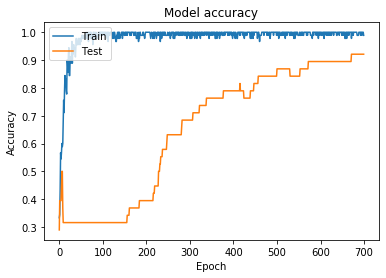

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Train and test on GT_split 2

In [11]:
Train_2 = pickle.load(open(C.data_dir+"GT_train_2.pkl", "rb"))
Test_2 = pickle.load(open(C.data_dir+"GT_test_2.pkl", "rb"))

le = preprocessing.LabelEncoder()
le.fit(Train_2['label'])
print(le.classes_)

X_0,X_1,Y = data_generator(Train_2,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test_2,C,le)

  0%|          | 0/90 [00:00<?, ?it/s]

['catch' 'sit' 'walk']


100%|██████████| 38/38 [00:00<00:00, 317.37it/s]


In [12]:
# Re-initialize weights, since training and testing data switch
DD_Net = build_DD_Net(C)
DD_Net.compile(loss="categorical_crossentropy",optimizer=Adam(lr),metrics=['accuracy'])
lrScheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
modelCpkt = ModelCheckpoint('./weights_split_2/epoch_{epoch:02d}-val_acc_{val_acc:.2f}', monitor='val_acc', 
                            mode='max', save_best_only=True, save_weights_only=True, 
                            load_weights_on_restart=True)
history = DD_Net.fit([X_0,X_1], Y, 
                     batch_size=len(Y),
                     epochs=700,
                     verbose=True,
                     shuffle=True,
                     callbacks=[lrScheduler, modelCpkt],
                     validation_data=([X_test_0,X_test_1],Y_test),
                     class_weight=class_weight
                    )

Train on 90 samples, validate on 38 samples
Epoch 1/700
90/90 [==============================] - 3s 30ms/sample - loss: 1.3870 - acc: 0.4000 - val_loss: 1.0985 - val_acc: 0.3421
Epoch 2/700
90/90 [==============================] - 0s 1ms/sample - loss: 1.2941 - acc: 0.4000 - val_loss: 1.0974 - val_acc: 0.3158
Epoch 3/700
90/90 [==============================] - 0s 1ms/sample - loss: 1.1088 - acc: 0.5222 - val_loss: 1.0958 - val_acc: 0.2368
Epoch 4/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.9463 - acc: 0.6000 - val_loss: 1.0952 - val_acc: 0.2632
Epoch 5/700
90/90 [==============================] - 0s 1ms/sample - loss: 1.0288 - acc: 0.5889 - val_loss: 1.0948 - val_acc: 0.1842
Epoch 6/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.8489 - acc: 0.6889 - val_loss: 1.0938 - val_acc: 0.2895
Epoch 7/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.7522 - acc: 0.7000 - val_loss: 1.0925 - val_acc: 0.2895
Epoch 8/700
90/90 [=====

Epoch 62/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.2195 - acc: 0.9444 - val_loss: 1.1701 - val_acc: 0.3158
Epoch 63/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.2112 - acc: 0.9222 - val_loss: 1.1731 - val_acc: 0.3158
Epoch 64/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.2270 - acc: 0.9222 - val_loss: 1.1756 - val_acc: 0.3158
Epoch 65/700
90/90 [==============================] - 0s 2ms/sample - loss: 0.1984 - acc: 0.9444 - val_loss: 1.1788 - val_acc: 0.3158
Epoch 66/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.2269 - acc: 0.9444 - val_loss: 1.1816 - val_acc: 0.3158
Epoch 67/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.2337 - acc: 0.9333 - val_loss: 1.1841 - val_acc: 0.3158
Epoch 68/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1769 - acc: 0.9667 - val_loss: 1.1874 - val_acc: 0.3158
Epoch 69/700
90/90 [==============================] - 0s 1ms/s

Epoch 123/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1971 - acc: 0.9556 - val_loss: 1.3262 - val_acc: 0.3158
Epoch 124/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1663 - acc: 0.9667 - val_loss: 1.3275 - val_acc: 0.3158
Epoch 125/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1400 - acc: 0.9889 - val_loss: 1.3287 - val_acc: 0.3158
Epoch 126/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1661 - acc: 0.9556 - val_loss: 1.3302 - val_acc: 0.3158
Epoch 127/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1959 - acc: 0.9556 - val_loss: 1.3315 - val_acc: 0.3158
Epoch 128/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1884 - acc: 0.9667 - val_loss: 1.3322 - val_acc: 0.3158
Epoch 129/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1791 - acc: 0.9556 - val_loss: 1.3335 - val_acc: 0.3158
Epoch 130/700
90/90 [==============================] - 

Epoch 184/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1426 - acc: 0.9667 - val_loss: 1.2493 - val_acc: 0.3947
Epoch 185/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1530 - acc: 0.9889 - val_loss: 1.2451 - val_acc: 0.3947
Epoch 186/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1982 - acc: 0.9222 - val_loss: 1.2408 - val_acc: 0.3947
Epoch 187/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1694 - acc: 0.9667 - val_loss: 1.2362 - val_acc: 0.3947
Epoch 188/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1116 - acc: 1.0000 - val_loss: 1.2331 - val_acc: 0.3947
Epoch 189/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1457 - acc: 0.9778 - val_loss: 1.2282 - val_acc: 0.3947
Epoch 190/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1577 - acc: 0.9667 - val_loss: 1.2235 - val_acc: 0.3947
Epoch 191/700
90/90 [==============================] - 

Epoch 245/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1203 - acc: 1.0000 - val_loss: 0.9423 - val_acc: 0.5526
Epoch 246/700
90/90 [==============================] - 0s 2ms/sample - loss: 0.1407 - acc: 0.9778 - val_loss: 0.9369 - val_acc: 0.5789
Epoch 247/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1166 - acc: 1.0000 - val_loss: 0.9320 - val_acc: 0.5789
Epoch 248/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1444 - acc: 0.9778 - val_loss: 0.9279 - val_acc: 0.5789
Epoch 249/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1392 - acc: 0.9667 - val_loss: 0.9221 - val_acc: 0.5789
Epoch 250/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1040 - acc: 0.9889 - val_loss: 0.9158 - val_acc: 0.5789
Epoch 251/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1717 - acc: 0.9444 - val_loss: 0.9113 - val_acc: 0.5789
Epoch 252/700
90/90 [==============================] - 

Epoch 306/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1713 - acc: 0.9444 - val_loss: 0.6520 - val_acc: 0.7105
Epoch 307/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0857 - acc: 0.9889 - val_loss: 0.6483 - val_acc: 0.7105
Epoch 308/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0856 - acc: 0.9889 - val_loss: 0.6454 - val_acc: 0.7105
Epoch 309/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1280 - acc: 0.9889 - val_loss: 0.6426 - val_acc: 0.7105
Epoch 310/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1158 - acc: 0.9889 - val_loss: 0.6402 - val_acc: 0.7105
Epoch 311/700
90/90 [==============================] - 0s 2ms/sample - loss: 0.1303 - acc: 0.9667 - val_loss: 0.6375 - val_acc: 0.7105
Epoch 312/700
90/90 [==============================] - 0s 2ms/sample - loss: 0.1003 - acc: 0.9889 - val_loss: 0.6345 - val_acc: 0.7105
Epoch 313/700
90/90 [==============================] - 

Epoch 367/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0893 - acc: 0.9889 - val_loss: 0.4821 - val_acc: 0.8158
Epoch 368/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1281 - acc: 0.9778 - val_loss: 0.4804 - val_acc: 0.8158
Epoch 369/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1033 - acc: 0.9778 - val_loss: 0.4789 - val_acc: 0.8158
Epoch 370/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1096 - acc: 0.9778 - val_loss: 0.4772 - val_acc: 0.8158
Epoch 371/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1333 - acc: 0.9889 - val_loss: 0.4759 - val_acc: 0.8158
Epoch 372/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1423 - acc: 0.9667 - val_loss: 0.4736 - val_acc: 0.8158
Epoch 373/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0888 - acc: 1.0000 - val_loss: 0.4721 - val_acc: 0.8158
Epoch 374/700
90/90 [==============================] - 

Epoch 428/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0940 - acc: 0.9778 - val_loss: 0.3986 - val_acc: 0.9211
Epoch 429/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0976 - acc: 0.9889 - val_loss: 0.3972 - val_acc: 0.9211
Epoch 430/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0888 - acc: 0.9778 - val_loss: 0.3953 - val_acc: 0.9211
Epoch 431/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1054 - acc: 0.9889 - val_loss: 0.3942 - val_acc: 0.9211
Epoch 432/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1117 - acc: 0.9778 - val_loss: 0.3930 - val_acc: 0.9211
Epoch 433/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0915 - acc: 1.0000 - val_loss: 0.3916 - val_acc: 0.9211
Epoch 434/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0948 - acc: 1.0000 - val_loss: 0.3902 - val_acc: 0.9211
Epoch 435/700
90/90 [==============================] - 

Epoch 489/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0612 - acc: 1.0000 - val_loss: 0.3533 - val_acc: 0.9211
Epoch 490/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0998 - acc: 0.9889 - val_loss: 0.3529 - val_acc: 0.9211
Epoch 491/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1014 - acc: 0.9667 - val_loss: 0.3526 - val_acc: 0.9211
Epoch 492/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0905 - acc: 0.9889 - val_loss: 0.3525 - val_acc: 0.9211
Epoch 493/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1011 - acc: 0.9889 - val_loss: 0.3521 - val_acc: 0.9211
Epoch 494/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0643 - acc: 1.0000 - val_loss: 0.3514 - val_acc: 0.9211
Epoch 495/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0848 - acc: 0.9778 - val_loss: 0.3511 - val_acc: 0.9211
Epoch 496/700
90/90 [==============================] - 

Epoch 550/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0819 - acc: 0.9889 - val_loss: 0.3339 - val_acc: 0.9474
Epoch 551/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0938 - acc: 0.9889 - val_loss: 0.3338 - val_acc: 0.9474
Epoch 552/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0852 - acc: 0.9889 - val_loss: 0.3335 - val_acc: 0.9474
Epoch 553/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0612 - acc: 1.0000 - val_loss: 0.3330 - val_acc: 0.9474
Epoch 554/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0708 - acc: 0.9889 - val_loss: 0.3326 - val_acc: 0.9474
Epoch 555/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0895 - acc: 0.9667 - val_loss: 0.3325 - val_acc: 0.9474
Epoch 556/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0647 - acc: 0.9889 - val_loss: 0.3319 - val_acc: 0.9474
Epoch 557/700
90/90 [==============================] - 

Epoch 611/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0917 - acc: 0.9778 - val_loss: 0.3149 - val_acc: 0.9474
Epoch 612/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0744 - acc: 0.9889 - val_loss: 0.3145 - val_acc: 0.9474
Epoch 613/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0667 - acc: 0.9889 - val_loss: 0.3141 - val_acc: 0.9474
Epoch 614/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1040 - acc: 0.9667 - val_loss: 0.3138 - val_acc: 0.9474
Epoch 615/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0808 - acc: 0.9778 - val_loss: 0.3137 - val_acc: 0.9474
Epoch 616/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0597 - acc: 1.0000 - val_loss: 0.3134 - val_acc: 0.9474
Epoch 617/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1078 - acc: 0.9667 - val_loss: 0.3131 - val_acc: 0.9474
Epoch 618/700
90/90 [==============================] - 

Epoch 672/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0618 - acc: 0.9889 - val_loss: 0.3063 - val_acc: 0.9474
Epoch 673/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0524 - acc: 1.0000 - val_loss: 0.3063 - val_acc: 0.9474
Epoch 674/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0869 - acc: 0.9778 - val_loss: 0.3059 - val_acc: 0.9474
Epoch 675/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0815 - acc: 0.9778 - val_loss: 0.3055 - val_acc: 0.9474
Epoch 676/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0504 - acc: 1.0000 - val_loss: 0.3052 - val_acc: 0.9474
Epoch 677/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0354 - acc: 1.0000 - val_loss: 0.3049 - val_acc: 0.9474
Epoch 678/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0434 - acc: 1.0000 - val_loss: 0.3048 - val_acc: 0.9474
Epoch 679/700
90/90 [==============================] - 

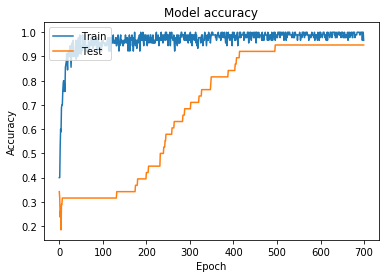

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Train and test on GT_split 3

In [14]:
Train_3 = pickle.load(open(C.data_dir+"GT_train_3.pkl", "rb"))
Test_3 = pickle.load(open(C.data_dir+"GT_test_3.pkl", "rb"))

le = preprocessing.LabelEncoder()
le.fit(Train_3['label'])
print(le.classes_)

X_0,X_1,Y = data_generator(Train_3,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test_3,C,le)

  0%|          | 0/90 [00:00<?, ?it/s]

['catch' 'sit' 'walk']


100%|██████████| 38/38 [00:00<00:00, 352.17it/s]


In [15]:
# Re-initialize weights, since training and testing data switch
DD_Net = build_DD_Net(C)
DD_Net.compile(loss="categorical_crossentropy",optimizer=Adam(lr),metrics=['accuracy'])
lrScheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
modelCpkt = ModelCheckpoint('./weights_split_3/epoch_{epoch:02d}-val_acc_{val_acc:.2f}', monitor='val_acc', 
                            mode='max', save_best_only=True, save_weights_only=True, 
                            load_weights_on_restart=True)
history = DD_Net.fit([X_0,X_1], Y, 
                     batch_size=len(Y),
                     epochs=700,
                     verbose=True,
                     shuffle=True,
                     callbacks=[lrScheduler, modelCpkt],
                     validation_data=([X_test_0,X_test_1],Y_test),
                     class_weight=class_weight
                    )

Train on 90 samples, validate on 38 samples
Epoch 1/700
90/90 [==============================] - 3s 35ms/sample - loss: 1.5015 - acc: 0.3333 - val_loss: 1.0968 - val_acc: 0.3421
Epoch 2/700
90/90 [==============================] - 0s 1ms/sample - loss: 1.4430 - acc: 0.4111 - val_loss: 1.0976 - val_acc: 0.2895
Epoch 3/700
90/90 [==============================] - 0s 1ms/sample - loss: 1.3485 - acc: 0.4333 - val_loss: 1.0994 - val_acc: 0.3158
Epoch 4/700
90/90 [==============================] - 0s 1ms/sample - loss: 1.3926 - acc: 0.3889 - val_loss: 1.1005 - val_acc: 0.3158
Epoch 5/700
90/90 [==============================] - 0s 1ms/sample - loss: 1.2374 - acc: 0.4333 - val_loss: 1.1008 - val_acc: 0.3158
Epoch 6/700
90/90 [==============================] - 0s 1ms/sample - loss: 1.0117 - acc: 0.5778 - val_loss: 1.1014 - val_acc: 0.3158
Epoch 7/700
90/90 [==============================] - 0s 1ms/sample - loss: 1.1304 - acc: 0.6000 - val_loss: 1.1021 - val_acc: 0.3158
Epoch 8/700
90/90 [=====

Epoch 62/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1420 - acc: 0.9667 - val_loss: 1.1795 - val_acc: 0.3158
Epoch 63/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1480 - acc: 0.9778 - val_loss: 1.1813 - val_acc: 0.3158
Epoch 64/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1501 - acc: 0.9667 - val_loss: 1.1823 - val_acc: 0.3158
Epoch 65/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1115 - acc: 0.9778 - val_loss: 1.1826 - val_acc: 0.3158
Epoch 66/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1369 - acc: 0.9667 - val_loss: 1.1834 - val_acc: 0.3158
Epoch 67/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1008 - acc: 0.9889 - val_loss: 1.1841 - val_acc: 0.3158
Epoch 68/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1363 - acc: 0.9889 - val_loss: 1.1850 - val_acc: 0.3158
Epoch 69/700
90/90 [==============================] - 0s 1ms/s

Epoch 123/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1154 - acc: 0.9778 - val_loss: 1.0947 - val_acc: 0.3158
Epoch 124/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1374 - acc: 0.9556 - val_loss: 1.0910 - val_acc: 0.3158
Epoch 125/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1219 - acc: 0.9778 - val_loss: 1.0873 - val_acc: 0.3158
Epoch 126/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0909 - acc: 1.0000 - val_loss: 1.0844 - val_acc: 0.3158
Epoch 127/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1243 - acc: 0.9778 - val_loss: 1.0814 - val_acc: 0.3158
Epoch 128/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1127 - acc: 0.9778 - val_loss: 1.0775 - val_acc: 0.3158
Epoch 129/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1091 - acc: 0.9667 - val_loss: 1.0741 - val_acc: 0.3158
Epoch 130/700
90/90 [==============================] - 

Epoch 184/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1335 - acc: 0.9556 - val_loss: 0.8647 - val_acc: 0.6579
Epoch 185/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0765 - acc: 0.9889 - val_loss: 0.8610 - val_acc: 0.6579
Epoch 186/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1941 - acc: 0.9333 - val_loss: 0.8566 - val_acc: 0.6579
Epoch 187/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1123 - acc: 0.9778 - val_loss: 0.8525 - val_acc: 0.6579
Epoch 188/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1267 - acc: 0.9778 - val_loss: 0.8481 - val_acc: 0.6579
Epoch 189/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0891 - acc: 0.9889 - val_loss: 0.8446 - val_acc: 0.6579
Epoch 190/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0996 - acc: 0.9889 - val_loss: 0.8410 - val_acc: 0.6579
Epoch 191/700
90/90 [==============================] - 

Epoch 245/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0791 - acc: 0.9889 - val_loss: 0.6693 - val_acc: 0.6316
Epoch 246/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0893 - acc: 1.0000 - val_loss: 0.6668 - val_acc: 0.6316
Epoch 247/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0643 - acc: 1.0000 - val_loss: 0.6643 - val_acc: 0.6579
Epoch 248/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1294 - acc: 0.9778 - val_loss: 0.6617 - val_acc: 0.6579
Epoch 249/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1410 - acc: 0.9333 - val_loss: 0.6586 - val_acc: 0.6579
Epoch 250/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1027 - acc: 0.9889 - val_loss: 0.6556 - val_acc: 0.6579
Epoch 251/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0850 - acc: 0.9889 - val_loss: 0.6531 - val_acc: 0.6579
Epoch 252/700
90/90 [==============================] - 

Epoch 306/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0955 - acc: 0.9778 - val_loss: 0.5095 - val_acc: 0.7105
Epoch 307/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1353 - acc: 0.9667 - val_loss: 0.5073 - val_acc: 0.7105
Epoch 308/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0995 - acc: 0.9889 - val_loss: 0.5048 - val_acc: 0.7105
Epoch 309/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0840 - acc: 0.9889 - val_loss: 0.5023 - val_acc: 0.7105
Epoch 310/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0740 - acc: 1.0000 - val_loss: 0.5001 - val_acc: 0.6842
Epoch 311/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1027 - acc: 0.9778 - val_loss: 0.4979 - val_acc: 0.6842
Epoch 312/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0691 - acc: 1.0000 - val_loss: 0.4959 - val_acc: 0.6842
Epoch 313/700
90/90 [==============================] - 

Epoch 367/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0758 - acc: 0.9889 - val_loss: 0.4096 - val_acc: 0.7895
Epoch 368/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0624 - acc: 1.0000 - val_loss: 0.4085 - val_acc: 0.7895
Epoch 369/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1253 - acc: 0.9556 - val_loss: 0.4074 - val_acc: 0.7895
Epoch 370/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0847 - acc: 0.9889 - val_loss: 0.4068 - val_acc: 0.7895
Epoch 371/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0663 - acc: 1.0000 - val_loss: 0.4063 - val_acc: 0.7895
Epoch 372/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0954 - acc: 0.9667 - val_loss: 0.4054 - val_acc: 0.7895
Epoch 373/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0576 - acc: 1.0000 - val_loss: 0.4048 - val_acc: 0.7895
Epoch 374/700
90/90 [==============================] - 

Epoch 428/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0933 - acc: 1.0000 - val_loss: 0.3704 - val_acc: 0.7895
Epoch 429/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1040 - acc: 0.9556 - val_loss: 0.3697 - val_acc: 0.7895
Epoch 430/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0677 - acc: 0.9889 - val_loss: 0.3692 - val_acc: 0.7895
Epoch 431/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0664 - acc: 0.9889 - val_loss: 0.3688 - val_acc: 0.7895
Epoch 432/700
90/90 [==============================] - 0s 2ms/sample - loss: 0.0819 - acc: 0.9889 - val_loss: 0.3684 - val_acc: 0.8158
Epoch 433/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0669 - acc: 1.0000 - val_loss: 0.3680 - val_acc: 0.8158
Epoch 434/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.1103 - acc: 0.9778 - val_loss: 0.3678 - val_acc: 0.8158
Epoch 435/700
90/90 [==============================] - 

Epoch 489/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0929 - acc: 0.9667 - val_loss: 0.3406 - val_acc: 0.8421
Epoch 490/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0828 - acc: 0.9889 - val_loss: 0.3403 - val_acc: 0.8421
Epoch 491/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0778 - acc: 0.9889 - val_loss: 0.3398 - val_acc: 0.8421
Epoch 492/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0812 - acc: 0.9778 - val_loss: 0.3394 - val_acc: 0.8421
Epoch 493/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0497 - acc: 1.0000 - val_loss: 0.3392 - val_acc: 0.8421
Epoch 494/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0596 - acc: 1.0000 - val_loss: 0.3388 - val_acc: 0.8421
Epoch 495/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0915 - acc: 0.9778 - val_loss: 0.3386 - val_acc: 0.8421
Epoch 496/700
90/90 [==============================] - 

Epoch 550/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0686 - acc: 1.0000 - val_loss: 0.3226 - val_acc: 0.8421
Epoch 551/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0834 - acc: 0.9778 - val_loss: 0.3225 - val_acc: 0.8421
Epoch 552/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0597 - acc: 1.0000 - val_loss: 0.3225 - val_acc: 0.8421
Epoch 553/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0750 - acc: 0.9889 - val_loss: 0.3226 - val_acc: 0.8421
Epoch 554/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0502 - acc: 1.0000 - val_loss: 0.3228 - val_acc: 0.8421
Epoch 555/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0445 - acc: 1.0000 - val_loss: 0.3228 - val_acc: 0.8421
Epoch 556/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0727 - acc: 0.9889 - val_loss: 0.3227 - val_acc: 0.8421
Epoch 557/700
90/90 [==============================] - 

Epoch 611/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0405 - acc: 1.0000 - val_loss: 0.3217 - val_acc: 0.8421
Epoch 612/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0471 - acc: 1.0000 - val_loss: 0.3215 - val_acc: 0.8421
Epoch 613/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0705 - acc: 0.9889 - val_loss: 0.3212 - val_acc: 0.8421
Epoch 614/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0637 - acc: 0.9889 - val_loss: 0.3210 - val_acc: 0.8421
Epoch 615/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0428 - acc: 1.0000 - val_loss: 0.3210 - val_acc: 0.8421
Epoch 616/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0538 - acc: 1.0000 - val_loss: 0.3209 - val_acc: 0.8421
Epoch 617/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0508 - acc: 1.0000 - val_loss: 0.3207 - val_acc: 0.8421
Epoch 618/700
90/90 [==============================] - 

Epoch 672/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0401 - acc: 1.0000 - val_loss: 0.3383 - val_acc: 0.8158
Epoch 673/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0460 - acc: 1.0000 - val_loss: 0.3384 - val_acc: 0.8158
Epoch 674/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0521 - acc: 1.0000 - val_loss: 0.3386 - val_acc: 0.8158
Epoch 675/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0628 - acc: 1.0000 - val_loss: 0.3389 - val_acc: 0.8158
Epoch 676/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0395 - acc: 1.0000 - val_loss: 0.3393 - val_acc: 0.8158
Epoch 677/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0498 - acc: 0.9889 - val_loss: 0.3395 - val_acc: 0.8158
Epoch 678/700
90/90 [==============================] - 0s 1ms/sample - loss: 0.0480 - acc: 0.9889 - val_loss: 0.3395 - val_acc: 0.8158
Epoch 679/700
90/90 [==============================] - 

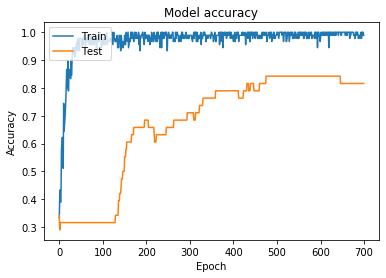

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
# DD_Net.save_weights('dd_net_weights/weights')

  0%|          | 0/270 [00:00<?, ?it/s]

['catch' 'sit' 'walk']


100%|██████████| 114/114 [00:00<00:00, 310.66it/s]


Train on 270 samples, validate on 114 samples
Epoch 1/700
270/270 [==============================] - 4s 15ms/sample - loss: 1.5299 - acc: 0.3444 - val_loss: 1.0967 - val_acc: 0.4211
Epoch 2/700
270/270 [==============================] - 0s 1ms/sample - loss: 1.4053 - acc: 0.3963 - val_loss: 1.0980 - val_acc: 0.4035
Epoch 3/700
270/270 [==============================] - 0s 1ms/sample - loss: 1.1853 - acc: 0.4741 - val_loss: 1.0989 - val_acc: 0.2982
Epoch 4/700
270/270 [==============================] - 0s 1ms/sample - loss: 1.1960 - acc: 0.5444 - val_loss: 1.0986 - val_acc: 0.4123
Epoch 5/700
270/270 [==============================] - 0s 1ms/sample - loss: 1.0674 - acc: 0.5852 - val_loss: 1.0979 - val_acc: 0.4561
Epoch 6/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.9981 - acc: 0.6407 - val_loss: 1.0969 - val_acc: 0.4825
Epoch 7/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.8530 - acc: 0.7259 - val_loss: 1.0956 - val_acc: 0.5175
Epoch 8/

Epoch 61/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0526 - acc: 0.9926 - val_loss: 1.0945 - val_acc: 0.3158
Epoch 62/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0795 - acc: 0.9815 - val_loss: 1.0954 - val_acc: 0.3158
Epoch 63/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0531 - acc: 0.9926 - val_loss: 1.0960 - val_acc: 0.3158
Epoch 64/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0825 - acc: 0.9778 - val_loss: 1.0957 - val_acc: 0.3158
Epoch 65/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0624 - acc: 0.9889 - val_loss: 1.0949 - val_acc: 0.3158
Epoch 66/700
270/270 [==============================] - 1s 4ms/sample - loss: 0.0591 - acc: 0.9926 - val_loss: 1.0945 - val_acc: 0.3158
Epoch 67/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0703 - acc: 0.9852 - val_loss: 1.0950 - val_acc: 0.3158
Epoch 68/700
270/270 [==========================

270/270 [==============================] - 0s 1ms/sample - loss: 0.0524 - acc: 0.9852 - val_loss: 1.1228 - val_acc: 0.3333
Epoch 122/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0362 - acc: 1.0000 - val_loss: 1.1212 - val_acc: 0.3333
Epoch 123/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0641 - acc: 0.9852 - val_loss: 1.1190 - val_acc: 0.3333
Epoch 124/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0462 - acc: 0.9926 - val_loss: 1.1168 - val_acc: 0.3333
Epoch 125/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0328 - acc: 1.0000 - val_loss: 1.1147 - val_acc: 0.3333
Epoch 126/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0514 - acc: 0.9926 - val_loss: 1.1126 - val_acc: 0.3333
Epoch 127/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0354 - acc: 0.9963 - val_loss: 1.1104 - val_acc: 0.3333
Epoch 128/700
270/270 [==============================] 

Epoch 181/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0450 - acc: 0.9889 - val_loss: 0.8420 - val_acc: 0.4123
Epoch 182/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0507 - acc: 0.9852 - val_loss: 0.8352 - val_acc: 0.4123
Epoch 183/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0474 - acc: 0.9889 - val_loss: 0.8289 - val_acc: 0.4123
Epoch 184/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0399 - acc: 0.9963 - val_loss: 0.8219 - val_acc: 0.4123
Epoch 185/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0448 - acc: 0.9926 - val_loss: 0.8150 - val_acc: 0.4123
Epoch 186/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0476 - acc: 0.9926 - val_loss: 0.8080 - val_acc: 0.4298
Epoch 187/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0317 - acc: 0.9963 - val_loss: 0.8006 - val_acc: 0.4298
Epoch 188/700
270/270 [==================

Epoch 241/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0322 - acc: 1.0000 - val_loss: 0.4647 - val_acc: 0.8070
Epoch 242/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0303 - acc: 0.9963 - val_loss: 0.4595 - val_acc: 0.8070
Epoch 243/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0316 - acc: 0.9963 - val_loss: 0.4544 - val_acc: 0.8070
Epoch 244/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0470 - acc: 0.9963 - val_loss: 0.4496 - val_acc: 0.8246
Epoch 245/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0364 - acc: 0.9926 - val_loss: 0.4446 - val_acc: 0.8246
Epoch 246/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0340 - acc: 0.9963 - val_loss: 0.4401 - val_acc: 0.8246
Epoch 247/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0334 - acc: 0.9963 - val_loss: 0.4354 - val_acc: 0.8333
Epoch 248/700
270/270 [==================

Epoch 301/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0328 - acc: 0.9963 - val_loss: 0.2698 - val_acc: 0.9298
Epoch 302/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0367 - acc: 0.9926 - val_loss: 0.2682 - val_acc: 0.9298
Epoch 303/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0393 - acc: 0.9926 - val_loss: 0.2667 - val_acc: 0.9298
Epoch 304/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0410 - acc: 0.9926 - val_loss: 0.2654 - val_acc: 0.9298
Epoch 305/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0370 - acc: 0.9926 - val_loss: 0.2641 - val_acc: 0.9298
Epoch 306/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0370 - acc: 0.9963 - val_loss: 0.2629 - val_acc: 0.9298
Epoch 307/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0492 - acc: 0.9926 - val_loss: 0.2615 - val_acc: 0.9298
Epoch 308/700
270/270 [==================

Epoch 361/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0264 - acc: 0.9963 - val_loss: 0.2127 - val_acc: 0.9474
Epoch 362/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0218 - acc: 1.0000 - val_loss: 0.2121 - val_acc: 0.9474
Epoch 363/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0327 - acc: 0.9926 - val_loss: 0.2116 - val_acc: 0.9474
Epoch 364/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0296 - acc: 1.0000 - val_loss: 0.2112 - val_acc: 0.9474
Epoch 365/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0338 - acc: 0.9963 - val_loss: 0.2108 - val_acc: 0.9474
Epoch 366/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0398 - acc: 0.9926 - val_loss: 0.2104 - val_acc: 0.9474
Epoch 367/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0383 - acc: 0.9889 - val_loss: 0.2099 - val_acc: 0.9474
Epoch 368/700
270/270 [==================

Epoch 421/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0251 - acc: 0.9963 - val_loss: 0.1735 - val_acc: 0.9649
Epoch 422/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0258 - acc: 1.0000 - val_loss: 0.1727 - val_acc: 0.9649
Epoch 423/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0225 - acc: 1.0000 - val_loss: 0.1718 - val_acc: 0.9649
Epoch 424/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0214 - acc: 1.0000 - val_loss: 0.1710 - val_acc: 0.9649
Epoch 425/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0250 - acc: 1.0000 - val_loss: 0.1704 - val_acc: 0.9649
Epoch 426/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0343 - acc: 1.0000 - val_loss: 0.1697 - val_acc: 0.9649
Epoch 427/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0321 - acc: 1.0000 - val_loss: 0.1692 - val_acc: 0.9649
Epoch 428/700
270/270 [==================

Epoch 481/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0256 - acc: 0.9926 - val_loss: 0.1349 - val_acc: 0.9649
Epoch 482/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0358 - acc: 0.9963 - val_loss: 0.1343 - val_acc: 0.9649
Epoch 483/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0254 - acc: 0.9963 - val_loss: 0.1336 - val_acc: 0.9649
Epoch 484/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0266 - acc: 0.9963 - val_loss: 0.1330 - val_acc: 0.9649
Epoch 485/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0291 - acc: 1.0000 - val_loss: 0.1322 - val_acc: 0.9649
Epoch 486/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0276 - acc: 0.9963 - val_loss: 0.1315 - val_acc: 0.9649
Epoch 487/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0397 - acc: 0.9926 - val_loss: 0.1307 - val_acc: 0.9649
Epoch 488/700
270/270 [==================

Epoch 541/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0221 - acc: 1.0000 - val_loss: 0.0964 - val_acc: 0.9737
Epoch 542/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0246 - acc: 0.9963 - val_loss: 0.0960 - val_acc: 0.9737
Epoch 543/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0244 - acc: 0.9963 - val_loss: 0.0957 - val_acc: 0.9737
Epoch 544/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0252 - acc: 0.9963 - val_loss: 0.0952 - val_acc: 0.9737
Epoch 545/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0227 - acc: 1.0000 - val_loss: 0.0947 - val_acc: 0.9737
Epoch 546/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0255 - acc: 0.9926 - val_loss: 0.0943 - val_acc: 0.9737
Epoch 547/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0240 - acc: 0.9963 - val_loss: 0.0939 - val_acc: 0.9737
Epoch 548/700
270/270 [==================

Epoch 601/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0206 - acc: 0.9963 - val_loss: 0.0678 - val_acc: 0.9737
Epoch 602/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0237 - acc: 0.9963 - val_loss: 0.0675 - val_acc: 0.9737
Epoch 603/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0206 - acc: 1.0000 - val_loss: 0.0671 - val_acc: 0.9737
Epoch 604/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0221 - acc: 0.9963 - val_loss: 0.0666 - val_acc: 0.9737
Epoch 605/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0179 - acc: 1.0000 - val_loss: 0.0660 - val_acc: 0.9737
Epoch 606/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0187 - acc: 1.0000 - val_loss: 0.0657 - val_acc: 0.9737
Epoch 607/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0301 - acc: 0.9926 - val_loss: 0.0652 - val_acc: 0.9737
Epoch 608/700
270/270 [==================

Epoch 661/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0188 - acc: 1.0000 - val_loss: 0.0382 - val_acc: 0.9737
Epoch 662/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0216 - acc: 1.0000 - val_loss: 0.0376 - val_acc: 0.9737
Epoch 663/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0167 - acc: 1.0000 - val_loss: 0.0372 - val_acc: 0.9737
Epoch 664/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0204 - acc: 1.0000 - val_loss: 0.0366 - val_acc: 0.9737
Epoch 665/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0210 - acc: 1.0000 - val_loss: 0.0362 - val_acc: 0.9737
Epoch 666/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0298 - acc: 0.9926 - val_loss: 0.0357 - val_acc: 0.9737
Epoch 667/700
270/270 [==============================] - 0s 1ms/sample - loss: 0.0184 - acc: 1.0000 - val_loss: 0.0353 - val_acc: 0.9737
Epoch 668/700
270/270 [==================

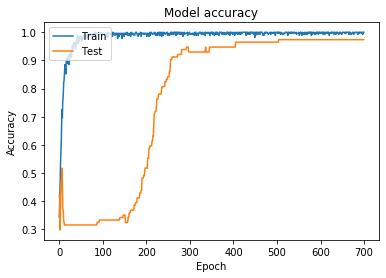

In [18]:
# Train_1 = pickle.load(open(C.data_dir+"GT_train_1.pkl", "rb"))
# Test_1 = pickle.load(open(C.data_dir+"GT_test_1.pkl", "rb"))
# Train_2 = pickle.load(open(C.data_dir+"GT_train_2.pkl", "rb"))
# Test_2 = pickle.load(open(C.data_dir+"GT_test_2.pkl", "rb"))
# Train_3 = pickle.load(open(C.data_dir+"GT_train_3.pkl", "rb"))
# Test_3 = pickle.load(open(C.data_dir+"GT_test_3.pkl", "rb"))
Train_1['pose'].extend(Train_2['pose'])
Train_1['label'].extend(Train_2['label'])
Test_1['pose'].extend(Test_2['pose'])
Test_1['label'].extend(Test_2['label'])
Train_1['pose'].extend(Train_3['pose'])
Train_1['label'].extend(Train_3['label'])
Test_1['pose'].extend(Test_3['pose'])
Test_1['label'].extend(Test_3['label'])
# print(len(Train_1['pose']))
# print(len(Train_1['label']))
# print(len(Test_1['pose']))
# print(len(Test_1['label']))

le = preprocessing.LabelEncoder()
le.fit(Train_1['label'])
print(le.classes_)
X_0,X_1,Y = data_generator(Train_1,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test_1,C,le)

DD_Net = build_DD_Net(C)
DD_Net.compile(loss="categorical_crossentropy",optimizer=Adam(lr),metrics=['accuracy'])
lrScheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
modelCpkt = ModelCheckpoint('./weights/epoch_{epoch:02d}-val_acc_{val_acc:.2f}', monitor='val_acc', 
                            mode='max', save_best_only=True, save_weights_only=True, 
                            load_weights_on_restart=True)
history = DD_Net.fit([X_0,X_1], Y, 
                     batch_size=len(Y),
                     epochs=700,
                     verbose=True,
                     shuffle=True,
                     callbacks=[lrScheduler, modelCpkt],
                     validation_data=([X_test_0,X_test_1],Y_test),
                     class_weight=class_weight
                    )
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
# DD_Net.save('dd-net.h5')

In [20]:
# le.inverse_transform(list(range(14)))